**классификатор текстов LSTM + W2V**

Евгений Борисов <esborisov@sevsu.ru>

## Данные

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()        
pd.options.display.max_colwidth = 200 

In [2]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

data = pd.concat([
    pd.read_csv('data/positive.csv.gz',sep=';',header=None),
    pd.read_csv('data/negative.csv.gz',sep=';',header=None),
])

data.columns = ff

data = data[['id','ttext', 'ttype']]

print( 'negative:', len(data.query('ttype==-1')), '\npositive:',len(data.query('ttype==1')) )

data.sample(10)

negative: 111923 
positive: 114911


,id,ttext,ttype
26557,412292846537175040,@CKAHAX че такое твитдэк только не ори на меня(,-1
33642,413269711968043008,@zen_pc многие остается неизменным:(. У самого iMac.,-1
102,408907829001465856,"Базарнов сегодня спрашивал - чем лучше сушиться :D Парень весит всего 60 кг где-то, ахаха. Но он сказал, что ему уже пора, лол",1
51920,415365097112862720,"@MLIK_RU опоил и не ""танцевал"" чтоли? (((",-1
79069,419431255076130816,"@DatBalto, :((((((((((((((999999999999999999999\nЯ буду ждать.(",-1
51000,410042700994707456,@The_first_life бытовая техника тоже хочет быть красивой),1
10250,410402136464187392,@irairairka Все не по книге. В серии увидишь(,-1
12928,410791532837752832,"RT @Fuckin_King_: @bald_unicorn7 я сильно,ооочень сильно скучаю((( го на днях в ск!*",-1
83717,419918478863523841,@Dilyara_Furduy @Lutick14 @Kamisama_dono я сегодня недайду до новых(,-1
86542,421143196299571200,@zveryuga_ru не хватает зловещего смеха. А вообще у них с детьми других проблем хватает - посерьезнее(,-1


### очистка данных

In [3]:
import re

In [4]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
      #[r'ё','е'] # замена ё для унификации
      #,[r'</?[a-z]+>',' '] # удаляем xml
      [r'[:;]-*[)D]',' радость ']
      ,[r'\)\)\)*',' радость ']
      ,[r'[:;]\*',' поцелуй ']
      ,[r':\(',' печаль ']
      ,[r'\(\(\(*',' печаль ']
    ]
    return replace_patterns(s,pat).strip()

In [5]:
data['ttext_'] = data['ttext'].progress_apply(string_normalizer)

  0%|          | 0/226834 [00:00<?, ?it/s]

In [8]:
from nltk.tokenize import word_tokenize as nltk_tokenize_word

def tokenize(line): # разбиваем предложения на слова
    return    [ 
        t.lower() 
        for t in nltk_tokenize_word(line) 
        if re.match(r'[а-я]+',t.lower()) and len(t)>1 
    ] 

In [9]:
data['ttext_'] = data['ttext_'].progress_apply(tokenize)

  0%|          | 0/226834 [00:00<?, ?it/s]

In [10]:
data.sample(10)

,id,ttext,ttype,ttext_
31418,409655408786423808,RT @ivahykys: Мне урок на будущее: никогда не спорить с долбоёбами. Никогда. Нервные клетки не восстанавливаются. :),1,"[мне, урок, на, будущее, никогда, не, спорить, долбоёбами, никогда, нервные, клетки, не, восстанавливаются, радость]"
20447,409414976097771520,"RT @BVB_Russe: Ну, граждане алкоголики, тунеядцы, хулиганы, кто желает поиграть за Боруссию? :)) В центре защиты - 2 человека. В центре пол…",1,"[ну, граждане, алкоголики, тунеядцы, хулиганы, кто, желает, поиграть, за, боруссию, радость, центре, защиты, человека, центре, пол…]"
18067,409377206964871168,"RT @OlgaAstraukh1: я беременна, поздравте меня)))\nуже на огурчики тянят=))) http://t.co/MJoJaIv9iu",1,"[беременна, поздравте, меня, радость, уже, на, огурчики, тянят=, радость]"
77951,410715520154210304,"ехать домой на транспорте было бы адом, так что метро х))",1,"[ехать, домой, на, транспорте, было, бы, адом, так, что, метро, радость]"
14768,409341391714934785,"RT @Creative_Link: Дождались! Официальный трейлер ""Иван Царевич и Серый Волк - 2"". Смотреть всем: http://t.co/gmelSGMIuW Толи еще будет)",1,"[дождались, официальный, трейлер, иван, царевич, серый, волк, смотреть, всем, толи, еще, будет]"
22443,409434017566818305,"Орфография хромает на обе ноги... толи пальцы кривые, то ли медленные... не успевают за мозгом печатать... :D",1,"[орфография, хромает, на, обе, ноги, толи, пальцы, кривые, то, ли, медленные, не, успевают, за, мозгом, печатать, радость]"
29443,409626951628759040,"Господи,если ты читаешь ТВИ...пошли мужика стоящего...желательно до конца этого года )",1,"[господи, если, ты, читаешь, тви, пошли, мужика, стоящего, желательно, до, конца, этого, года]"
63223,416889509469761536,"@ooLo_oLo мне всегда камаро нравились, выглядит классно",-1,"[мне, всегда, камаро, нравились, выглядит, классно]"
98628,423017314049466368,"@_wanna_die_ @ganzavextra соррьки, не смогу ((((((((((((((((9((99(99",-1,"[соррьки, не, смогу, печаль, печаль]"
17264,411209680535687168,Хочу широкий подоконник - неудобно быть ванилькой на узком(,-1,"[хочу, широкий, подоконник, неудобно, быть, ванилькой, на, узком]"


In [11]:
max_len = data['ttext_'].str.len().max() # максимальная длинна последовательности
max_len

35

In [12]:
data[ data['ttext_'].str.len()<1 ] # пустые последовательности

,id,ttext,ttype,ttext_
66829,410387338087632896,RT @olesyaglee: @ktyekmrf30 http://t.co/fBbOR9RPLn х),1,[]
70030,410465659223810048,RT @MilanaRepina: @LenocPlotnikova ❤спасиииибо) http://t.co/aO0vwsolYd,1,[]
77139,410705991714738176,RT @Mariya_Mila: С @ErmachonokAnton ) http://t.co/LmCxpsSoQG,1,[]
101718,411095547144306688,RT @Dasha_Jenner: @poolyasha П О Л Я \nТ Ы \nХ О Р О Ш А Я : ),1,[]
114606,411364795800354816,RT @sergey0495: http://t.co/dsvJIQP5Tgпробки 10баллов),1,[]
9374,410306860089364480,RT @_Batonchik_: @cekc_tyt @aabdullaeva1 @chemicalechelon @frank_james45 @herlocked @misty_marcie @mywhisper @to_over_kill @whoresdiefirst …,-1,[]
12183,410753661065625600,@Katyaaa_fly @Vituska1998 @daria_hey и я(,-1,[]
21396,411751245129744385,RT @SolarEclipse57: @girl_turner666 @SCOOB_JOE @Geronimo_woohoo @drinkthecyani @SolarEclipse57 @greennwood @BrianMolko_off @bananacookiee @…,-1,[]
28025,412591386681409536,@hasio_original и @whitebro_ http://t.co/dupuQSnm6D,-1,[]
29153,412648375071158272,@VasylevaMasha и я( http://t.co/GilYbA6TzZ,-1,[]


In [13]:
print( 'negative:', len(data.query('ttype==-1')), '\npositive:',len(data.query('ttype==1')) )

negative: 111923 
positive: 114911


In [14]:
# выкидываем пустые и очень короткие последовательности
data = data[ data['ttext_'].str.len()>2 ].reset_index(drop=True)
print( 'negative:', len(data.query('ttype==-1')), '\npositive:',len(data.query('ttype==1')) )

negative: 110564 
positive: 113791


### кодируем слова W2V

https://ruscorpora.ru/new/

https://nlpub.ru/Russian_Distributional_Thesaurus    

In [15]:
import numpy as np
from gensim.models.word2vec import KeyedVectors
# загружаем матрицу word2vec
w2v = KeyedVectors.load_word2vec_format('w2v/all.norm-sz100-w10-cb0-it1-min100.w2v',binary=True,limit=100000)

In [16]:
# 'радость' in w2v # True
# w2v.get_vector('радость').shape

In [17]:
# слова нет в словаре
# 'школота' in w2v # False
# w2v.get_vector('школота') # Error!

In [18]:
X = [ 
 [ w2v.get_vector(w) for w in l if w in w2v ]
 for l in tqdm( data['ttext_'] ) 
]

target = data['ttype']

  0%|          | 0/224355 [00:00<?, ?it/s]

In [19]:
w2v_len = len(X[0][0]) # размер представления W2V
w2v_len

100

In [20]:
# дополняем последовательности нулями до единого формата,
# выкидываем те, что не нашли соответствия в словаре W2V
z = np.zeros(w2v_len) 
target = np.array([ target[i] for i,xi in enumerate(X) if len(xi)>0 ])
X = np.array([ [z]*(max_len-len(xi)) + xi for xi in X if len(xi)>0  ],dtype=np.float32)
X.shape, target.shape

((224098, 35, 100), (224098,))

In [21]:
del w2v

In [22]:
target = (target+1)//2
y = np.eye(max(target)+1,dtype=np.float32)[target] # строим выход нейросети (из 2 нейронов)

In [23]:
from sklearn.model_selection import train_test_split

# делим данные для оценки
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=.4 )
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((134458, 35, 100), (134458, 2), (89640, 35, 100), (89640, 2))

In [24]:
del X
del target
del y

## модель

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [26]:
torch.__version__

'1.11.0+cu102'

In [27]:
input_dim = w2v_len
hidden_dim = 128
n_classes = 2

class Model(nn.Module):
    def __init__(self, 
                 input_dim=input_dim,  # размер входа
                 hid_dim=hidden_dim,   # размер рекуррентного слоя
                 output_dim=n_classes, # размер выхода
                ):
        super().__init__()
        self._rnn = nn.LSTM( input_dim, hid_dim, batch_first=True) # рекуррентный слой
        self._linear = nn.Linear(hid_dim, output_dim) # выходной (линейный) слой

    def forward(self,x):
        _, (hidden, _) = self._rnn(x) # обрабатываем входную последовательность
        # print(hidden.shape,out.shape)
        hidden = hidden.squeeze(0) # прекомпоновка тензора, сокращаем размерность
        out = self._linear(hidden) # считаем выход сети
        out = F.softmax(out,dim=1)
        return out 

In [28]:
model = Model()
model

Model(
  (_rnn): LSTM(100, 128, batch_first=True)
  (_linear): Linear(in_features=128, out_features=2, bias=True)
)

In [29]:
# o =  model.forward( torch.Tensor(x_train[:256]) ) # .to(device) )
# o.shape

### обучаем модель

In [30]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [31]:
model = model.to(device)

In [32]:
criterion =  nn.CrossEntropyLoss() # ф-ция потери
optimizer = torch.optim.Adam(model.parameters(), lr=.005) # метод оптимизации

In [33]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader # генератор батчей

# пакуем данные в формат Torch
dataset_train = TensorDataset(torch.tensor(x_train), torch.tensor(y_train) )

In [34]:
from sklearn.metrics import accuracy_score

def accuracy(dataset,model=model):
    with torch.set_grad_enabled(False):
        return np.mean([
            accuracy_score(
                y[:,1],
                np.argmax( model(x.to(device)).cpu().numpy(),axis=1 )
            )
            for x,y in DataLoader(dataset, batch_size=len(dataset)//100, shuffle=False)
        ])
        
acc_history = [ accuracy(dataset_train) ] # начальное значение погрешности

In [35]:
%%time

from torch.utils.data import DataLoader # генератор батчей

loss_history = [ ] # значения ф-ции потери
n_epoch = 7 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    
    # получаем батч учебных примеров
    for x,y in DataLoader(dataset_train, batch_size=len(y_train)//100, shuffle=True): 
        out = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( y.to(device),out ) # вычисляем значение ф-ции потери
        loss_history.append(loss.item()) # дополняем историю изменения значений ф-ции потери
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
        
    acc_history.append( accuracy(dataset_train) ) #значение погрешности

  0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 27.4 s, sys: 69.6 ms, total: 27.5 s
Wall time: 27 s


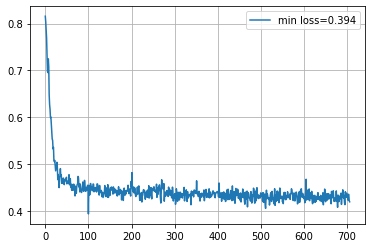

In [36]:
from matplotlib import pyplot as plt
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()

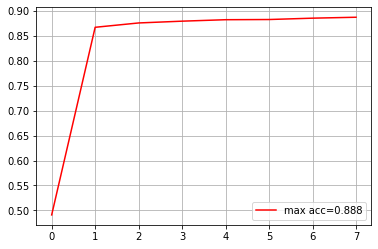

In [37]:
# история изменения значений погрешности модели
plt.plot(acc_history,label='max acc=%.3f'%(max(acc_history)),c='r')
plt.grid()
plt.legend()

## проверяем результат

In [38]:
dataset_test = TensorDataset(torch.tensor(x_test), torch.tensor(y_test) )

with torch.set_grad_enabled(False):
    o_test = np.hstack([
            np.argmax( model(x.to(device)).cpu().numpy(),axis=1 )
            for x,_ in DataLoader(dataset_test, batch_size=len(dataset_test)//100, shuffle=False)
        ])
    
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_test,axis=1),o_test))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88     44366
           1       0.87      0.90      0.88     45274

    accuracy                           0.88     89640
   macro avg       0.88      0.88      0.88     89640
weighted avg       0.88      0.88      0.88     89640

